In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# from skbio.diversity import alpha_diversity, beta_diversity
# from skbio.stats.ordination import pcoa, pcoa_biplotb
import random
from os.path import join
import pandas as pd
import xlsxwriter
import openpyxl
import os
import numpy as np
from pandas import Series, ExcelWriter
import scipy.io as sio
import scipy
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 
from anndata import AnnData
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys  
sys.path.insert(0, '../my_packages')
import dimen_reduc
import meta_ord
import paga_res
import sliding_window
import statistic

#### Variables

In [3]:
top_path = "C:/Users/morts/Documents/TAU/Manifold_Project/Data/Serrano_Ravel13_Ravel11_Carter22/"
    
file_name = top_path + 'all_df_25062023.xlsx'
sheet_abun = 'abundance'
sheet_meta = 'meta'

date = '18062023'

in_path = top_path + 'in_df_16052023.xlsx'
out_path = top_path + 'out_df_16052023.xlsx'

In [70]:
n_neighbors = 15
n_pcs = 30

#### Load data

In [71]:
in_df = pd.read_excel(in_path, sheet_name = sheet_abun, index_col = 0)
in_meta = pd.read_excel(in_path, sheet_name = sheet_meta, index_col = 0)
print(in_df.shape)
print(in_meta.shape)

(7842, 424)
(7842, 29)


#### Prepare for PAGA

In [7]:
in_meta.columns

Index(['sampleID', 'subjectID', 'day', 'week', 'time', 'ph', 'nugent', 'menst',
       'subCST', 'CST', 'score', 'db', 'nugnet', 'VAG_IRR', 'VAG_ITCH',
       'VAG_ODOR', 'age', 'ethnicity', 'symptoms', 'ABV', 'SBV',
       'BV_medication', 'shannon_index', 'whiff', 'clue', 'vag_fluid',
       'BV_status', 'BV_bin', 'root'],
      dtype='object')

#### Run UMAP and insert BC

In [72]:
in_df.sum(axis = 0).sort_values()#.hist()
filt_df = in_df[in_df.columns[in_df.sum() >= 1]]
s = filt_df.sum()
filt_df = filt_df[s.sort_values(ascending=False).index]
print(filt_df.shape)

(7842, 336)


In [123]:
adata = AnnData(X = filt_df.to_numpy(),
                        obs = in_meta[['CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root']],
                        var = pd.DataFrame(index = filt_df.columns))#,
#                         uns = {'pca': {}})
adata.X = adata.X.astype('float64')
# adata.obsm['X_pca'] = in_df.to_numpy()
# adata.uns['pca']['variance_ratio'] = pca_variance_ratio 
# adata.uns['pca']['variance'] = pca_variance 
# adata.varm['PCs'] = pca_loadings 

In [111]:
adata.X.shape

(7842, 336)

In [126]:
test

AnnData object with n_obs × n_vars = 7842 × 336
    obs: 'CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root'
    uns: 'neighbors'
    obsm: 'X_pca'
    obsp: 'distances', 'connectivities'

In [129]:
test = adata.copy()
test = sc.pp.neighbors(test, method = 'gauss', n_neighbors = 15, n_pcs = 50, metric = 'braycurtis', copy = True)

         Falling back to preprocessing with `sc.pp.pca` and default params.


ValueError: could not broadcast input array from shape (0,) into shape (14,)

In [106]:
sc.pp.neighbors(adata, method == 'gauss', n_neighbors = 15, n_pcs = 50, metric = 'braycurtis', use_rep = 'X')

ValueError: could not broadcast input array from shape (0,) into shape (14,)

In [98]:
pd.DataFrame(c_mat).to_csv(top_path + "umap_BC_connectivities.csv")
c_mat.shape

(7842, 7842)

In [103]:
c_mat = adata.obsp['distances'].todense()
print(c_mat.shape)
print(c_mat.sum(axis = 0))
print(c_mat.sum(axis = 0).max())
print((c_mat != 0).sum(0).max())

(7842, 7842)
[[0.33806061   0.1664914507 1.6615363248 ... 1.8067446016 0.0318513854
  0.0333240051]]
16.263919338583946
47


... storing 'CST' as categorical
... storing 'subCST' as categorical
... storing 'db' as categorical
... storing 'root' as categorical


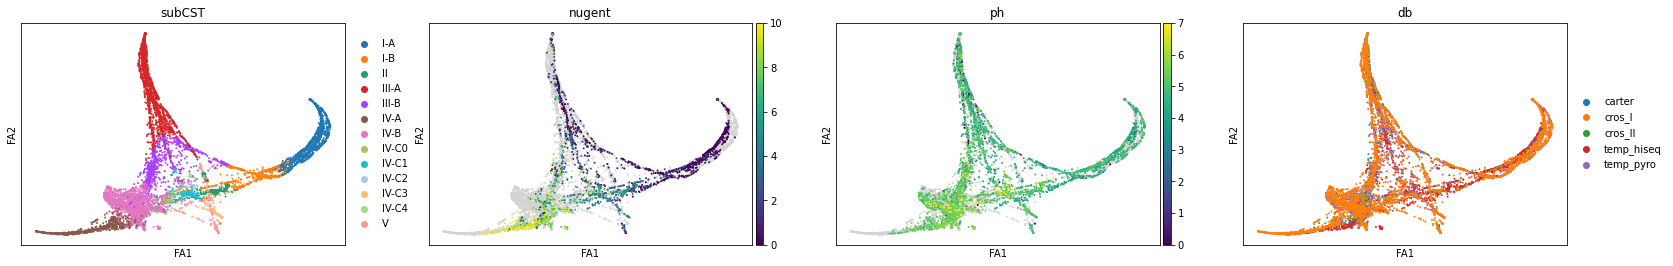

In [39]:
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color = ['subCST', 'nugent', 'ph', 'db'], legend_loc = 'right margin')

In [15]:
def run_umap(adata, n_neighbors, n_pcs, metric = 'braycurtis'):
    ## Create UMAP
    sc.pp.neighbors(adata, n_neighbors = n_neighbors, n_pcs = n_pcs, metric = metric)
    sc.tl.draw_graph(adata)
    sc.pl.draw_graph(adata, color = ['subCST', 'nugent', 'ph', 'db'], legend_loc = 'right margin')
    
    return adata

In [82]:
center_df = dimen_reduc.get_center(in_df)
pca_df, pca_loadings, pca_variance_ratio, pca_variance = dimen_reduc.get_pca_reg(center_df)
bc_dist = dimen_reduc.get_bc_dist(in_df)

In [92]:
squarer = lambda t: 1 - t
vfunc = np.vectorize(squarer)
bc_conc = vfunc(bc_dist.to_numpy())

In [101]:
adata = AnnData(X = in_df.to_numpy(),
                        obs = in_meta[['CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root']],
                        var = pd.DataFrame(index = in_df.columns),
                        uns = {'pca': {}})
adata.X = adata.X.astype('float64')
adata.obsm['X_pca'] = pca_df 
adata.uns['pca']['variance_ratio'] = pca_variance_ratio 
adata.uns['pca']['variance'] = pca_variance 
adata.varm['PCs'] = pca_loadings 

... storing 'CST' as categorical
... storing 'subCST' as categorical
... storing 'db' as categorical
... storing 'root' as categorical


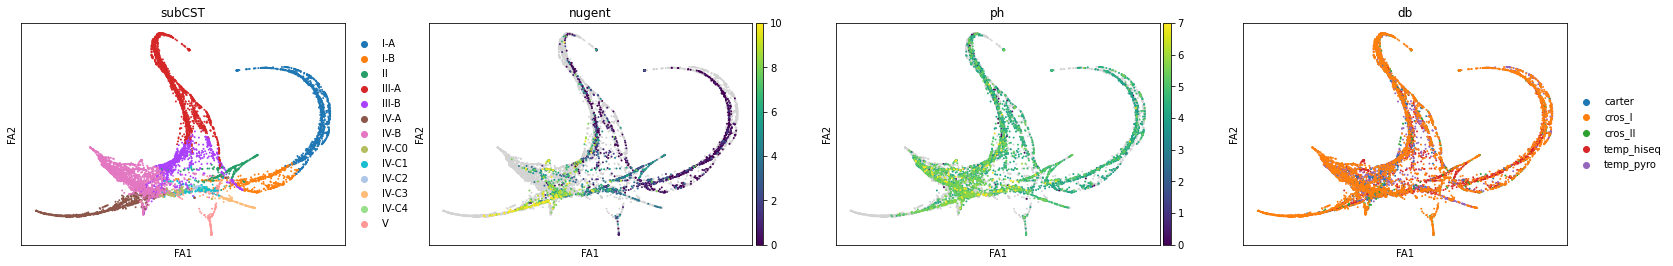

In [102]:
adata = run_umap(adata, n_neighbors, n_pcs)

#### Get pseudo-time

In [99]:
def leiden_clusters(adata):
    ## Leiden clusters
    sc.tl.leiden(adata, resolution=1.0)
    sc.tl.paga(adata, groups='leiden')
    sc.pl.draw_graph(adata, color=['CST', 'leiden'], legend_loc='on data')
    sc.pl.paga(adata, color=['leiden'])

    adata.obs['leiden_anno'] = adata.obs['leiden']
    sc.tl.paga(adata, groups = 'leiden_anno')
    
    return adata

def get_ps(adata, ps_col, ps_value):
    ## Pseudotime
    adata.uns['iroot'] = np.flatnonzero(adata.obs[ps_col] == ps_value)[0]
    sc.tl.dpt(adata)

    ## Plot pseudotime
    sc.pl.draw_graph(adata, color = ['leiden', 'subCST', 'dpt_pseudotime'], legend_loc='on data')

    return adata

In [100]:
adata = leiden_clusters(adata)

... storing 'CST' as categorical
... storing 'subCST' as categorical
... storing 'db' as categorical
... storing 'root' as categorical


KeyError: 'draw_graph'

In [104]:
adata.obsp['distances'] = bc_dist.to_numpy()
adata.obsp['connectivities'] = bc_conc

In [101]:
adata = get_ps(adata, 'root', 'root')

KeyError: 'draw_graph'

In [102]:
adata

AnnData object with n_obs × n_vars = 7842 × 336
    obs: 'CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root', 'leiden', 'dpt_pseudotime'
    uns: 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'iroot', 'diffmap_evals'
    obsm: 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [65]:
def paga_results(adata, df, meta, metric = 'euclidean'):
    ''' Input: adata, df, meta
    Output: dictionary of all dfs
    Run get 5 objects of adata results to dictionary'''
    names_lst = ['abundance', 'meta', 'umap', 'leiden']

    graph_df = pd.DataFrame(adata.obsm['X_draw_graph_fa'], index = meta.index, columns=['fa1', 'fa2'])

    ## Meta
    leiden_df = adata.obs['leiden'].to_frame()
    final_meta = meta.copy()
    final_meta.loc[:, 'dpt_pseudotime'] = adata.obs['dpt_pseudotime']
    final_meta.loc[:, 'mt_pseudotime'] = 1 - final_meta.loc[:, 'dpt_pseudotime']
    if metric == 'euclidean':
        pca_df = pd.DataFrame(adata.obsm['X_pca'])
        names_lst.append('pca')

    ## Save all in dict
    df_lst = [df, final_meta, graph_df, leiden_df]
    if metric == 'euclidean':
        df_lst.append(pca_df)
    dict_res = dict(zip(names_lst, df_lst))

    return dict_res

In [66]:
dict_res = paga_results(adata, filt_df, in_meta, 'braycurtis')
ps_path = top_path + 'ps_res/' + '/ps_res_' + str(date) + '_BC_X.xlsx'
paga_res.save_excel(ps_path, dict_res)

In [113]:
adata

AnnData object with n_obs × n_vars = 7842 × 424
    obs: 'CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root', 'leiden', 'leiden_anno', 'dpt_pseudotime'
    uns: 'pca', 'neighbors', 'draw_graph', 'subCST_colors', 'db_colors', 'leiden', 'paga', 'leiden_sizes', 'CST_colors', 'leiden_colors', 'leiden_anno_sizes', 'iroot', 'diffmap_evals'
    obsm: 'X_pca', 'X_draw_graph_fa', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [17]:
adata_umap

AnnData object with n_obs × n_vars = 7842 × 424
    obs: 'CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root'
    uns: 'pca', 'neighbors', 'draw_graph', 'subCST_colors', 'db_colors'
    obsm: 'X_pca', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [88]:
distances = adata.obsp[''].todense()
print(distances.shape)
ind_row, ind_col = np.nonzero(distances)
nonzero_lst = []
tup_lst = []
for i in range(len(ind_row)):
#     print(ind_row[i], ind_col[i])
#     print(distances[ind_row[i], ind_col[i]])
    tup_lst.append((ind_row[i], ind_col[i]))
    nonzero_lst.append(distances[ind_row[i], ind_col[i]])
# print(distances[ind_row[0], ind_col[0]])

(7842, 7842)


In [90]:
nonzero_lst.sort()
print(nonzero_lst)
one = [item for item in nonzero_lst if item == 1.0]
# print(len(one))

[1.0761371e-07, 1.0761371e-07, 1.383359e-07, 1.383359e-07, 1.5848843e-07, 1.5848843e-07, 2.549738e-07, 2.549738e-07, 3.164035e-07, 3.164035e-07, 4.8268646e-07, 4.8268646e-07, 5.508164e-07, 5.508164e-07, 5.6909465e-07, 5.6909465e-07, 7.280998e-07, 7.280998e-07, 7.346821e-07, 7.346821e-07, 7.360953e-07, 7.360953e-07, 7.4292774e-07, 7.4292774e-07, 8.44625e-07, 8.44625e-07, 8.5072764e-07, 8.5072764e-07, 8.945042e-07, 8.945042e-07, 9.3544264e-07, 9.3544264e-07, 1.0116476e-06, 1.0116476e-06, 1.0224867e-06, 1.0224867e-06, 1.1373207e-06, 1.1373207e-06, 1.1495392e-06, 1.1495392e-06, 1.3110471e-06, 1.3110471e-06, 1.5521023e-06, 1.5521023e-06, 1.5665656e-06, 1.5665656e-06, 1.5686242e-06, 1.5686242e-06, 1.7377018e-06, 1.7377018e-06, 1.7884804e-06, 1.7884804e-06, 2.0903612e-06, 2.0903612e-06, 2.1211667e-06, 2.1211667e-06, 2.4380415e-06, 2.4380415e-06, 2.4844544e-06, 2.4844544e-06, 2.4862818e-06, 2.4862818e-06, 2.577498e-06, 2.577498e-06, 3.46079e-06, 3.46079e-06, 3.6907645e-06, 3.6907645e-06, 3.714

In [73]:
[tup for tup in tup_lst if tup[0] == tup[1]]
# tup_lst

[]

In [80]:
distances[:10,:10]


0.0

In [24]:
adata.obsp['connectivities'].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [85]:
bc_dist.to_numpy().shape

(7842, 7842)

In [30]:
adata

AnnData object with n_obs × n_vars = 7842 × 424
    obs: 'CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [29]:
adata_copy = adata

In [31]:
sc.pp.neighbors(adata_copy, n_neighbors = n_neighbors, n_pcs = n_pcs)

In [32]:
adata_copy

AnnData object with n_obs × n_vars = 7842 × 424
    obs: 'CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [33]:
sc.tl.draw_graph(adata_copy)

In [36]:
print(adata_copy)
print(adata_copy.uns['neighbors'])

AnnData object with n_obs × n_vars = 7842 × 424
    obs: 'CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root'
    uns: 'pca', 'neighbors', 'draw_graph'
    obsm: 'X_pca', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 15, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'n_pcs': 30}}
With overloaded keys:
	['connectivities', 'distances'].


In [37]:
sc.tl.leiden(adata_copy, resolution=1.0)
print(adata_copy)

AnnData object with n_obs × n_vars = 7842 × 424
    obs: 'CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root', 'leiden'
    uns: 'pca', 'neighbors', 'draw_graph', 'leiden'
    obsm: 'X_pca', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [38]:
sc.tl.paga(adata_copy, groups='leiden')
print(adata_copy)

... storing 'CST' as categorical
... storing 'subCST' as categorical
... storing 'db' as categorical
... storing 'root' as categorical


AnnData object with n_obs × n_vars = 7842 × 424
    obs: 'CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root', 'leiden'
    uns: 'pca', 'neighbors', 'draw_graph', 'leiden', 'paga', 'leiden_sizes'
    obsm: 'X_pca', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [ ]:
sc.pl.paga(adata_copy, color=['leiden'])
print(adata_copy)

In [39]:
adata_copy.uns['iroot'] = np.flatnonzero(adata_copy.obs['root'] == 'root')[0]
sc.tl.dpt(adata_copy)
print(adata_copy)

AnnData object with n_obs × n_vars = 7842 × 424
    obs: 'CST', 'subCST', 'score', 'nugent', 'ph', 'db', 'root', 'leiden', 'dpt_pseudotime'
    uns: 'pca', 'neighbors', 'draw_graph', 'leiden', 'paga', 'leiden_sizes', 'iroot', 'diffmap_evals'
    obsm: 'X_pca', 'X_draw_graph_fa', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [ ]:
## Leiden clusters
sc.tl.leiden(adata, resolution=1.0)
sc.tl.paga(adata, groups='leiden')
sc.pl.draw_graph(adata, color=['CST', 'leiden'], legend_loc='on data')
sc.pl.paga(adata, color=['leiden'])

adata.obs['leiden_anno'] = adata.obs['leiden']
sc.tl.paga(adata, groups = 'leiden_anno')

## Pseudotime
adata.uns['iroot'] = np.flatnonzero(adata.obs[ps_col] == ps_value)[0]
sc.tl.dpt(adata)

## Plot pseudotime
sc.pl.draw_graph(adata, color=['leiden', 'subCST', 'dpt_pseudotime'], legend_loc='on data')